In [ ]:
%config Completer.use_jedi = False
import numpy as np
import pandas as pd
import sklearn.preprocessing as skp
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

from utils import dmd, dmdc, dmdtd, dmdctd, generate_data
import matplotlib
def rcparams(r=0.5):
    matplotlib.rcParams['font.size'] = 25 * r
    matplotlib.rcParams['xtick.labelsize'] = 20 * r
    matplotlib.rcParams['ytick.labelsize'] = 20 * r
    matplotlib.rcParams['axes.labelsize'] = 25 * r
    matplotlib.rcParams['legend.title_fontsize'] = 17 * r
    matplotlib.rcParams['legend.fontsize'] = 17 * r
    matplotlib.rcParams['axes.axisbelow'] = True
    matplotlib.rcParams['figure.figsize'] = [6 * r, 6 * r]


# format axis
def format_axis(ax):
    from matplotlib.ticker import (AutoMinorLocator)
    ax.xaxis.set_minor_locator(AutoMinorLocator())
    ax.yaxis.set_minor_locator(AutoMinorLocator())
    ax.tick_params(which='both', width=2)
    ax.tick_params(which='major', length=6)
    ax.tick_params(which='minor', length=3)
    ax.locator_params(axis='x', nbins=5)
    ax.locator_params(axis='y', nbins=5)
    for axis in ['top', 'bottom', 'left', 'right']:
        ax.spines[axis].set_linewidth(1.5)

### load data

In [ ]:
def load_data(train=96, test=24, holiday=True):
    path = '/Users/sjiang87/data_weight/atmospheric/data/Hourly_data_of_Beijing_from_Jinxi_interpolated.csv'
    df = pd.read_csv(path)
    if holiday:
        keys = ['Holiday', 'ERA5_d2m', 'ERA5_t2m', 'ERA5_rh', 'ERA5_sp', 'ERA5_u10', 'ERA5_v10', 'ERA5_blh', 'SO2', 'PM2.5', 'PM10', 'CO', 'NO2', 'O3']
    else:
        keys = ['ERA5_d2m', 'ERA5_t2m', 'ERA5_rh', 'ERA5_sp', 'ERA5_u10', 'ERA5_v10', 'ERA5_blh', 'SO2', 'PM2.5', 'PM10', 'CO', 'NO2', 'O3']
    # we have 34 uniques sites
    sites = df['Site'].values
    unique_sites = np.unique(sites)
    # each site has data of 14 * 8760, first 12 are control variables, last 2 are labels
    x = []
    for unique_site in unique_sites:
        ind = sites == unique_site
        df_temp = df[keys].iloc[ind].interpolate().copy()
        if holiday:
            df_holiday = skp.OneHotEncoder().fit_transform(df_temp.Holiday.values.reshape(-1, 1)).toarray()
            df_rest = df_temp.values[:, 1:].astype('float')
            df_temp = np.concatenate((df_holiday, df_rest), axis=1)
        x.append(skp.MinMaxScaler().fit_transform(df_temp))
    x = np.array(x).transpose((2, 0, 1))
    # u is control, x is label
    u = x[:-6, :]
    x = x[-6:, :]
    x_train, x_test, u_train, u_test = generate_data(x, u, train, test)
    

    return x_train, x_test, u_train, u_test

In [ ]:
x, x_future, u, u_future = load_data(train=10, test=2, holiday=True)
print(f"x: {x.shape}")
print(f"x_future: {x_future.shape}")
print(f"u: {u.shape}")
print(f"u_future: {u_future.shape}")

### train test split

In [ ]:
from sklearn.model_selection import train_test_split
ind = np.arange(x.shape[0])
ind_train, ind_test, _, _ = train_test_split(ind, ind, random_state=0, test_size=0.3)

### vanilla dmd
single site train

In [ ]:
x_trues, x_preds = [], []
for i in ind_train:
    for s in range(34):
        x_true, x_recons, x_fut, x_forcast, A = dmd(x, x_future, i=i, s=s, 
                                                    n_train=x.shape[-1], n_test=x_future.shape[-1], r=1)
        x_trues.append(x_true)
        x_preds.append(x_recons)
x_trues = np.ravel(x_trues)
x_preds = np.ravel(x_preds)

In [85]:
mean_squared_error(x_trues, x_preds) ** 2

6.400514100185815e-05

In [40]:
x_trues, x_preds = [], []
for i in ind_train:
    x_true, x_recons, x_fut, x_forcast, A = dmd(x, x_future, i=i, s='all', 
                                                n_train=x.shape[-1], n_test=x_future.shape[-1], r=1)
    x_trues.append(x_true)
    x_preds.append(x_recons)
x_trues = np.ravel(x_trues)
x_preds = np.ravel(x_preds)

In [41]:
mean_squared_error(x_trues, x_preds)

0.0024715873450992963

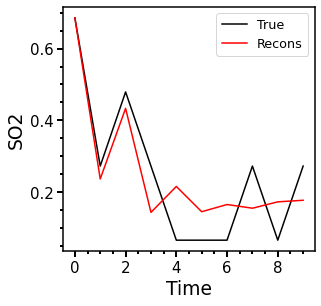

In [12]:
rcparams(0.75)
fig, ax = plt.subplots()
ax.plot(x_true[0], 'k', label='True',)
ax.plot(x_recons[0], 'r', label='Recons')
ax.set_xlabel('Time')
ax.set_ylabel('SO2')
ax.legend()
format_axis(ax)
plt.show()

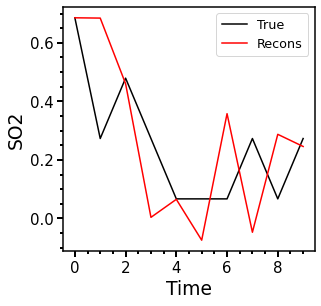

In [10]:
x_true, x_recons, x_future, x_pred, A = dmd(x_train, x_test, i=1, s='all', n_train=10, n_test=2)
rcparams(0.75)
fig, ax = plt.subplots()
ax.plot(x_true[0], 'k', label='True',)
ax.plot(x_recons[0], 'r', label='Recons')
ax.set_xlabel('Time')
ax.set_ylabel('SO2')
ax.legend()
format_axis(ax)
plt.show()

### dmd with time delay

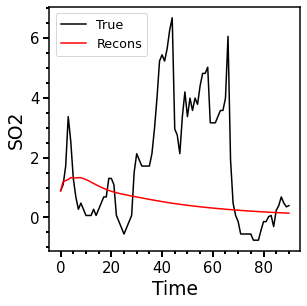

In [167]:
x_true, x_recons, x_future, x_pred = dmdtd(x_train, x_test, i=1, s=0, n_train=96, n_test=24, delay=6)
rcparams(0.75)
fig, ax = plt.subplots()
ax.plot(x_true[0], 'k', label='True',)
ax.plot(x_recons[0], 'r', label='Recons')
ax.set_xlabel('Time')
ax.set_ylabel('SO2')
ax.legend()
format_axis(ax)
plt.show()

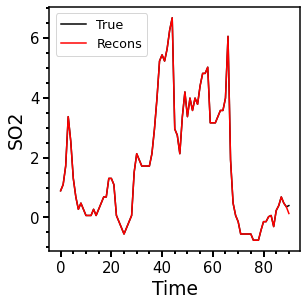

In [168]:
x_true, x_recons, x_future, x_pred = dmdtd(x_train, x_test, i=1, s='all', n_train=96, n_test=24, delay=6)
rcparams(0.75)
fig, ax = plt.subplots()
ax.plot(x_true[0], 'k', label='True',)
ax.plot(x_recons[0], 'r', label='Recons')
ax.set_xlabel('Time')
ax.set_ylabel('SO2')
ax.legend()
format_axis(ax)
plt.show()

### dmd with control

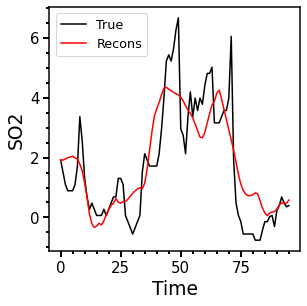

In [169]:
x_true, x_recons, x_future, x_pred, B = dmdc(x_train, x_test, u_train, u_test, i=1, s=0, n_train=96, n_test=24)
rcparams(0.75)
fig, ax = plt.subplots()
ax.plot(x_true[0], 'k', label='True',)
ax.plot(x_recons[0], 'r', label='Recons')
ax.set_xlabel('Time')
ax.set_ylabel('SO2')
ax.legend()
format_axis(ax)
plt.show()

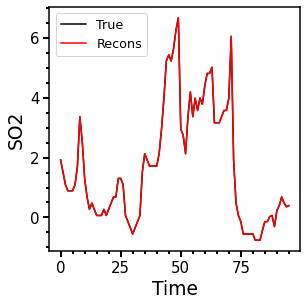

In [170]:
x_true, x_recons, x_future, x_pred, B = dmdc(x_train, x_test, u_train, u_test, i=1, s='all', n_train=96, n_test=24)
rcparams(0.75)
fig, ax = plt.subplots()
ax.plot(x_true[0], 'k', label='True',)
ax.plot(x_recons[0], 'r', label='Recons')
ax.set_xlabel('Time')
ax.set_ylabel('SO2')
ax.legend()
format_axis(ax)
plt.show()

### dmd with control and time delay

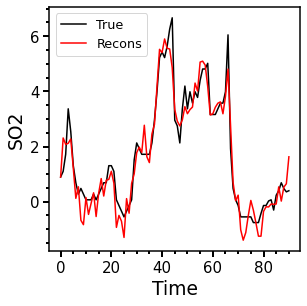

In [171]:
x_true, x_recons, x_future, x_pred, B = dmdctd(x_train, x_test, u_train, u_test, i=1, s=0, n_train=96, n_test=24, delay=6)
rcparams(0.75)
fig, ax = plt.subplots()
ax.plot(x_true[0], 'k', label='True',)
ax.plot(x_recons[0], 'r', label='Recons')
ax.set_xlabel('Time')
ax.set_ylabel('SO2')
ax.legend()
format_axis(ax)
plt.show()

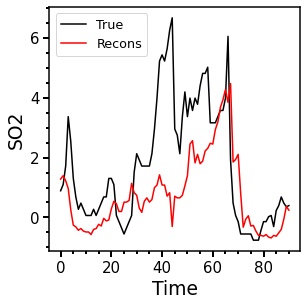

In [172]:
x_true, x_recons, x_future, x_pred, B = dmdctd(x_train, x_test, u_train, u_test, i=1, s='all', n_train=96, n_test=24, delay=6)
rcparams(0.75)
fig, ax = plt.subplots()
ax.plot(x_true[0], 'k', label='True',)
ax.plot(x_recons[0], 'r', label='Recons')
ax.set_xlabel('Time')
ax.set_ylabel('SO2')
ax.legend()
format_axis(ax)
plt.show()

In [8]:
# define parameters
i = 0 # start time
s = 1 # site number
n_train = 24 * 4 # amount of training time (hrs) for reconstruction
n_test = 24 * 1 # amount of testing time (hrs) for future prediction
delay = 3
n = n_train + n_test

# generate training and testing state variables
x_train, x_test, u_train, u_test = load_data(holiday=True)

# record error
err_1, err_2 = [[], [], [], []], [[], [], [], []]

# record B
B_all = []

for i in np.arange(0, 8760 - n, n):
    x_true, x_recons, x_future, x_pred = dmd(x_train, x_test, i, s, n_train, n_test)
    err_1[0].append(skm.mean_squared_error(x_true, x_recons) ** 0.5)
    err_2[0].append(skm.mean_squared_error(x_future, x_pred) ** 0.5)

    
    x_true, x_recons, x_future, x_pred, B = dmdc(x_train, x_test, u_train, u_test, i, s, n_train, n_test)
    err_1[1].append(skm.mean_squared_error(x_true, x_recons) ** 0.5)
    err_2[1].append(skm.mean_squared_error(x_future, x_pred) ** 0.5)
    
    x_true, x_recons, x_future, x_pred = dmdtd(x_train, x_test, i, s, n_train, n_test, delay)
    err_1[2].append(skm.mean_squared_error(x_true, x_recons) ** 0.5)
    err_2[2].append(skm.mean_squared_error(x_future, x_pred) ** 0.5)
    
    x_true, x_recons, x_future, x_pred, _ = dmdctd(x_train, x_test, u_train, u_test, i, s, n_train, n_test, delay)
    err_1[3].append(skm.mean_squared_error(x_true, x_recons) ** 0.5)
    err_2[3].append(skm.mean_squared_error(x_future, x_pred) ** 0.5)
    B_all.append(B)

In [9]:
err_1_new, err_2_new = [], []
B_all = np.array(B_all)
B_new = []
names = ['DMD', 'DMD with Forcing', 'DMD with Time Delay', 'DMD with Forcing and Time Delay']
for i, name in enumerate(names):
    err_1_temp = np.array(err_1[i])
    err_2_temp = np.array(err_2[i])
    
    if i == 1:
        index_1 = np.argsort(err_1_temp)[14:-14]
        B_new.append(B_all[index_1, 0, :])
        index_2 = np.argsort(err_2_temp)[14:-14]
        B_new.append(B_all[index_2, 1, :])
    
    err_1_temp = sorted(err_1_temp)[14:-14]
    err_2_temp = sorted(err_2_temp)[14:-14]
    
    
    err_1_new.append(err_1_temp)
    err_2_new.append(err_2_temp)
    print(name)
    print(f'Reconstruction Error: {np.mean(err_1_temp): 0.4f} +/- {np.std(err_1_temp): 0.4f}')
    print(f'Prediction Error:     {np.mean(err_2_temp): 0.4f} +/- {np.std(err_2_temp): 0.4f}')

DMD
Reconstruction Error:  0.6201 +/-  0.1707
Prediction Error:      0.5666 +/-  0.0991
DMD with Forcing
Reconstruction Error:  0.4507 +/-  0.1588
Prediction Error:      1.3008 +/-  0.9795
DMD with Time Delay
Reconstruction Error:  0.6134 +/-  0.1745
Prediction Error:      0.5626 +/-  0.1027
DMD with Forcing and Time Delay
Reconstruction Error:  0.3054 +/-  0.0927
Prediction Error:      1.3627 +/-  0.6825


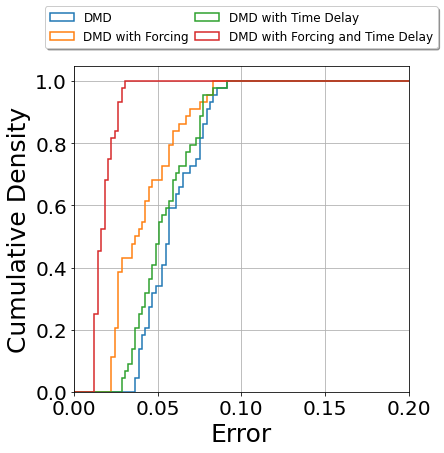

In [116]:
rcparams(1)
fig, ax = plt.subplots()
for i in range(4):
    ax.hist(err_1_new[i], bins=np.linspace(0, 0.201, 100), linewidth=1.5, cumulative=True, density=True, histtype='step', label=names[i])
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.2),
          ncol=2, fancybox=True, shadow=True, columnspacing=0.5, fontsize=12)
ax.set_xlim([0, 0.2])
ax.set_xlabel('Error')
ax.set_ylabel('Cumulative Density')
ax.grid()
format(ax)
plt.show()

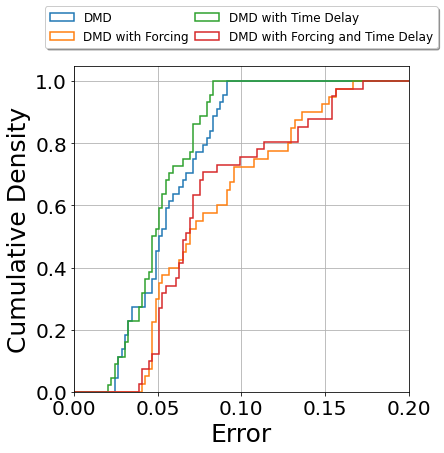

In [117]:
rcparams(1)
fig, ax = plt.subplots()
for i in range(4):
    ax.hist(err_2_new[i], bins=np.linspace(0, 0.201, 100), linewidth=1.5, cumulative=True, density=True, histtype='step', label=names[i])
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.2),
          ncol=2, fancybox=True, shadow=True, columnspacing=0.5, fontsize=12)
ax.set_xlim([0, 0.2])
ax.set_xlabel('Error')
ax.set_ylabel('Cumulative Density')
ax.grid()
format(ax)
plt.show()

In [120]:
B_all = np.array(B_all)
B_all.shape

(72, 2, 10)

In [131]:
u_train[:, :, 0, 0].sum(axis=0)

array([ 696.        , 6840.        , 1104.        , 5144.37158756,
       4329.18465482, 3931.48264387, 3973.94800325, 3559.67083326,
       4763.38528412,  952.01402275])

In [10]:
keys = ['Holiday', 'Weekday', 'Weekend', 'Dew point at 2 meters',
         'Temperature at 2 meters',
         'Relative humidity',
         'Surface pressure', 
         '10m U wind component', 
         '10m V wind component',
         'Boundary layer height', 'SO2', 'PM2.5']

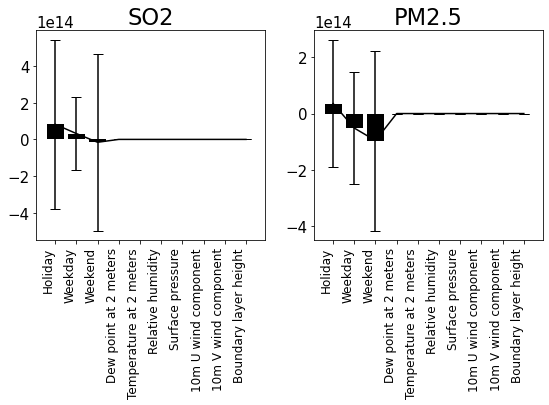

In [11]:
rcparams(0.75)
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8, 6))
for i in range(2):
    mean = B_new[i].mean(axis=0)
    std = B_new[i].std(axis=0)
    ax[i].errorbar(np.arange(len(mean)), mean, std, color='k', capsize=5)
    ax[i].bar(np.arange(len(mean)), mean, color='k')
    ax[i].set_title(keys[-2+i])
    ax[i].set_xticks(np.arange(len(mean)))
    ax[i].set_xticklabels(keys[:len(mean)], rotation=90, ha='right', fontsize=12)
    #format_axis(ax[i])
plt.tight_layout()
# plt.savefig(f'B.png', bbox_inches='tight')

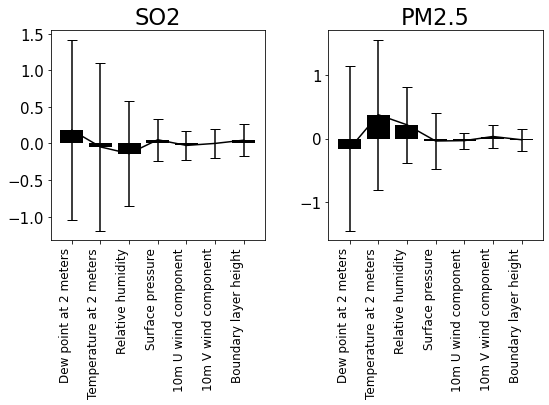

In [12]:
rcparams(0.75)
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8, 6))
for i in range(2):
    mean = B_new[i].mean(axis=0)[3:]
    std = B_new[i].std(axis=0)[3:]
    ax[i].errorbar(np.arange(len(mean)), mean, std, color='k', capsize=5)
    ax[i].bar(np.arange(len(mean)), mean, color='k')
    ax[i].set_title(keys[-2+i])
    ax[i].set_xticks(np.arange(len(mean)))
    ax[i].set_xticklabels(keys[3:3+len(mean)], rotation=90, ha='right', fontsize=12)
    #format_axis(ax[i])
plt.tight_layout()
# plt.savefig(f'B.png', bbox_inches='tight')

In [152]:
u_train[:, :, 0, 0].mean(axis=0)

array([ 0.00408034, -0.00028115, -0.00295378,  0.01805277,  0.01965512,
        0.0051041 , -0.01504022, -0.00238602,  0.00769142,  0.0026633 ])